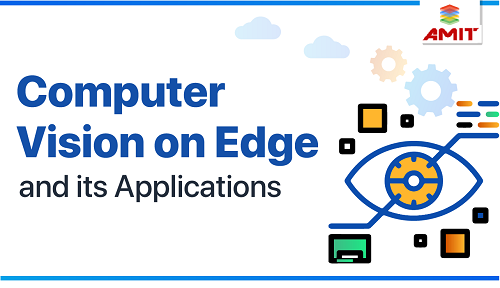

## This final project focuses on leveraging the techniques and concepts you've learned throughout this course. 
- You will apply image processing, feature extraction, and pattern recognition methods to solve real-world challenges. Specifically, you will implement and fine-tune state-of-the-art algorithms like Convolutional Neural Networks (CNNs), object detection, image segmentation, or even feature matching.

we'll build a CNN using Keras to use it classifying thousands of pictures in six different categories

Data link : https://www.kaggle.com/puneet6060/intel-image-classification

#Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob as gb
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from tqdm import tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support


#define the path ( to swtich it between jupyter notebook & kaggle kernel)

In [2]:
os.getcwd()
train_path='D:/Computer vision/project/archive/seg_train/seg_train'
test_path='D:/Computer vision/project/archive/seg_test/seg_test'
pred_path='D:/Computer vision/project/archive/seg_pred/seg_pred'

# Open Folders

now let's first check the Train folder to have a look to its content

In [3]:
def count_images_in_folders(base_path, description, is_subfolder=False):
    """
    Counts and prints the number of images in each folder within the specified base path.

    Parameters:
    - base_path: The path containing subfolders with images.
    - description: A string describing the type of data (e.g., 'training', 'testing', or 'prediction').
    - is_subfolder: Set to True if you want to count images in all subfolders.
    """
    if is_subfolder:
        # If we want to search through subfolders
        for folder in os.listdir(base_path):
            folder_path = os.path.join(base_path, folder)
            images = gb.glob(os.path.join(folder_path, '*.jpg'))
            print(f'For {description} data, found {len(images)} images in folder "{folder}".')
    else:
        # Only count images in the immediate subfolders
        files = gb.glob(os.path.join(base_path, '*.jpg'))
        print(f'For {description} data, found {len(files)} images.')


# Count images in training, testing, and prediction data
count_images_in_folders(train_path, 'training', is_subfolder=True)
count_images_in_folders(test_path, 'testing', is_subfolder=True)
count_images_in_folders(pred_path, 'prediction', is_subfolder=False)

For training data, found 2191 images in folder "buildings".
For training data, found 2271 images in folder "forest".
For training data, found 2404 images in folder "glacier".
For training data, found 2512 images in folder "mountain".
For training data, found 2274 images in folder "sea".
For training data, found 2382 images in folder "street".
For testing data, found 437 images in folder "buildings".
For testing data, found 474 images in folder "forest".
For testing data, found 553 images in folder "glacier".
For testing data, found 525 images in folder "mountain".
For testing data, found 510 images in folder "sea".
For testing data, found 501 images in folder "street".
For prediction data, found 7301 images.


#Checking Images
now we need to heck the images sizes , to know ow they looks like

since we have 6 categories , we first need to create a dictionary with their names & indices , also create a function to get the code back

In [4]:
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def get_code(n):
    for x,y in code.items():
        if n==y:
            return x
get_code(3)

'mountain'

In [5]:
def get_image_sizes(image_path, is_subfolder=False):
    """
    This function calculates the sizes of images in the given path.
    
    Parameters:
    - image_path: Path where images are stored.
    - is_subfolder: Set to True if the images are in subfolders (like train/test sets).
    
    Returns:
    - A pandas Series with the count of each image size.
    """
    sizes = []

    if is_subfolder:
        for folder in os.listdir(image_path):
            images = gb.glob(pathname=str(image_path + '/' + folder + '/*.jpg'))
            for img in images:
                image = plt.imread(img)
                sizes.append(image.shape)
    else:
        files = gb.glob(pathname=str(image_path + '/*.jpg'))
        for file in files:
            image = plt.imread(file)
            sizes.append(image.shape)

    return pd.Series(sizes).value_counts()

# Usage examples
train_sizes = get_image_sizes(train_path, is_subfolder=True)
test_sizes = get_image_sizes(test_path, is_subfolder=True)
pred_sizes = get_image_sizes(pred_path, is_subfolder=False)

print("Train Image Sizes:\n", train_sizes)
print("Test Image Sizes:\n", test_sizes)
print("Prediction Image Sizes:\n", pred_sizes)

Train Image Sizes:
 (150, 150, 3)    13986
(113, 150, 3)        7
(111, 150, 3)        3
(135, 150, 3)        3
(144, 150, 3)        2
(123, 150, 3)        2
(142, 150, 3)        2
(146, 150, 3)        2
(143, 150, 3)        2
(134, 150, 3)        2
(136, 150, 3)        2
(108, 150, 3)        2
(105, 150, 3)        1
(97, 150, 3)         1
(131, 150, 3)        1
(147, 150, 3)        1
(81, 150, 3)         1
(145, 150, 3)        1
(141, 150, 3)        1
(100, 150, 3)        1
(103, 150, 3)        1
(76, 150, 3)         1
(120, 150, 3)        1
(102, 150, 3)        1
(119, 150, 3)        1
(133, 150, 3)        1
(115, 150, 3)        1
(124, 150, 3)        1
(110, 150, 3)        1
(149, 150, 3)        1
(140, 150, 3)        1
Name: count, dtype: int64
Test Image Sizes:
 (150, 150, 3)    2993
(141, 150, 3)       1
(110, 150, 3)       1
(76, 150, 3)        1
(149, 150, 3)       1
(72, 150, 3)        1
(131, 150, 3)       1
(81, 150, 3)        1
Name: count, dtype: int64
Prediction Image Siz

ok , since almost all of pictures are 150,150,3 , we can feel comfort in using all pictures in our model , after resizing it in a specific amount

#Reading Images
now it's time to read all images & convert it into arrays

first we'll create a variable s , which refer to size , so we can change it easily

let's use now size = 100 , so it will be suitable amount to contain accuracy without losing so much time in training

In [12]:
def load_images(image_path, code, resize_shape=(100, 100), is_subfolder=True):
    """
    Loads and resizes images from the specified path.
    
    Parameters:
    - image_path: Path where images are stored.
    - code: A dictionary mapping folder names to labels.
    - resize_shape: Tuple specifying the new size for resizing images (default is (100, 100)).
    - is_subfolder: Boolean indicating if images are in subfolders (True for train/test, False for prediction).
    
    Returns:
    - x_data: A NumPy array of resized images.
    - y_data: Corresponding labels (if applicable, else returns None for prediction data).
    """
    x_data = []
    y_data = []

    if is_subfolder:
        for folder in os.listdir(image_path):
            folder_path = os.path.join(image_path, folder)
            images = gb.glob(pathname=os.path.join(folder_path, '*.jpg'))
            for img_path in images:
                image = plt.imread(img_path)  # Alternatively, you can use cv2.imread for BGR images
                image_resized = cv2.resize(image, resize_shape)
                x_data.append(image_resized)
                y_data.append(code[folder])  # Append the folder's label
    else:
        images = gb.glob(pathname=os.path.join(image_path, '*.jpg'))
        for img_path in images:
            image = cv2.imread(img_path)
            image_resized = cv2.resize(image, resize_shape)
            x_data.append(image_resized)
        y_data = None  # No labels for prediction data

    return np.array(x_data), np.array(y_data)

# Usage for train data
x_train, y_train = load_images(train_path, code, resize_shape=(100, 100), is_subfolder=True)

# Usage for test data
x_test, y_test = load_images(test_path, code, resize_shape=(100, 100), is_subfolder=True)

# Usage for prediction data (no labels)
x_pred, _ = load_images(pred_path, code=None, resize_shape=(100, 100), is_subfolder=False)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
print(f"x_pred shape: {x_pred.shape}")

x_train shape: (14034, 100, 100, 3), y_train shape: (14034,)
x_test shape: (3000, 100, 100, 3), y_test shape: (3000,)
x_pred shape: (7301, 100, 100, 3)


In [13]:

# Set a random seed for reproducibility
np.random.seed(42)

# Initialize lists to hold the sampled indices
indices_train = []

# Sample 1000 elements from each category
for category in range(6):
    category_indices = np.where(y_train == category)[0]  # Get indices of the current category
    sampled_indices = np.random.choice(category_indices, size=1000, replace=False)  # Sample 1000 indices
    indices_train.extend(sampled_indices)  # Append the sampled indices

# Convert to numpy array for further processing
indices_train = np.array(indices_train)

# Randomly sample 500 test samples from x_test (unchanged from your original code)
indices_test = np.random.choice(len(x_test), size=500, replace=False)

# Use the sampled indices to create the new training and test sets
x_train_sampled = np.array(x_train)[indices_train]
y_train_sampled = np.array(y_train)[indices_train]
x_test_sampled = np.array(x_test)[indices_test]
y_test_sampled = np.array(y_test)[indices_test]

# If you have predictions (x_pred) defined
x_pred_sampled = np.array(x_pred)[:300]

# Print shapes of the resulting arrays
print(x_train_sampled.shape)
print(x_test_sampled.shape)
print(y_train_sampled.shape)
print(y_test_sampled.shape)
print(x_pred_sampled.shape)

(6000, 100, 100, 3)
(500, 100, 100, 3)
(6000,)
(500,)
(300, 100, 100, 3)


In [25]:
#implement same as vgg16
# Define the model
KerasModel = models.Sequential([
    layers.Conv2D(200, activation='relu', kernel_size=(3, 3), padding='same', input_shape=(100, 100, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(180, activation='relu', kernel_size=(3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(160, activation='relu', kernel_size=(3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    
    layers.Conv2D(140, activation='relu', kernel_size=(3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(120, activation='relu', kernel_size=(3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    
    layers.Conv2D(100, activation='relu', kernel_size=(3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(80, activation='relu', kernel_size=(3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(60, activation='relu', kernel_size=(3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    
    layers.Conv2D(140, activation='relu', kernel_size=(3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(120, activation='relu', kernel_size=(3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    
    layers.Conv2D(50, activation='relu', kernel_size=(3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(40, activation='relu', kernel_size=(3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(40, activation='relu', kernel_size=(3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(30, activation='relu', kernel_size=(3, 3), padding='same'),
    layers.BatchNormalization(),
    
    layers.Conv2D(20, activation='relu', kernel_size=(3, 3), padding='same'),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(50, activation='relu'),
    layers.Dense(30, activation='relu'),
    layers.Dropout(rate=0.5),
    layers.Dense(6, activation='softmax')
])

# Summary of the model
KerasModel.summary()

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_45 (Conv2D)              │ (None, 100, 100, 200)  │         5,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 100, 100, 200)  │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 100, 100, 180)  │       324,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 100, 100, 180)  │           720 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 100, 100, 160)  │       259,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 100, 100, 160)  │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 50, 50, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 50, 50, 140)    │       201,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 50, 50, 140)    │           560 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 50, 50, 120)    │       151,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 50, 50, 120)    │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 25, 25, 120)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 25, 25, 100)    │       108,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 25, 25, 100)    │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 25, 25, 80)     │        72,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 25, 25, 80)     │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 25, 25, 60)     │        43,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 25, 25, 60)     │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 12, 12, 140)    │        75,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 12, 12, 140)    │           56

 Total params: 1,539,166 (5.87 MB)

 Trainable params: 1,536,206 (5.86 MB)

 Non-trainable params: 2,960 (11.56 KB)

In [26]:
KerasModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1, mode='max')

model_save_path = 'D:\Computer vision\project\model.keras'  # Specify your desired path and filename
vgg16_save_path = 'D:\Computer vision\project\vgg16.h5'  # Specify your desired path and filename
ResNet_save_path = 'D:\Computer vision\project\ResNet.h5'  # Specify your desired path and filename
Inception_save_path = 'D:\Computer vision\project\Inception.h5'  # Specify your desired path and filename

In [28]:

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    model_save_path,
    monitor='val_accuracy',  # Monitor validation loss; change to 'val_accuracy' if desired
    save_best_only=True,  # Save only the best model
    mode='max',  # 'max' for loss, 'max' for accuracy
    verbose=1  # Verbosity mode, 1 = save messages
)

# Train the model with the ModelCheckpoint callback
model = KerasModel.fit(
    x_train_sampled,
    y_train_sampled,
    validation_data=(x_test_sampled, y_test_sampled),  # Make sure to include validation data
    epochs=10,
    batch_size=64,
    verbose=1,
    callbacks=[checkpoint, early]  # Pass the checkpoint callback here
)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.2537 - loss: 1.8691 
Epoch 1: val_accuracy improved from -inf to 0.16200, saving model to D:\Computer vision\project\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 3157s 33s/step - accuracy: 0.2546 - loss: 1.8663 - val_accuracy: 0.1620 - val_loss: 4.7139
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.5432 - loss: 1.2059 
Epoch 2: val_accuracy improved from 0.16200 to 0.53200, saving model to D:\Computer vision\project\model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 3137s 33s/step - accuracy: 0.5434 - loss: 1.2054 - val_accuracy: 0.5320 - val_loss: 1.2637
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.6089 - loss: 1.0613 
Epoch 3: val_accuracy did not improve from 0.53200
94/94 ━━━━━━━━━━━━━━━━━━━━ 3137s 33s/step - accuracy: 0.6089 - loss: 1.0612 - val_accuracy: 0.5140 - val_loss: 1.7251
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.6683 - loss: 0.9449 
Epoch 4: val_accuracy improved from 

In [30]:
loss,accuracy=KerasModel.evaluate(x_test,y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.6792 - loss: 0.9101


In [32]:
print(f'loss is {loss}')
print(f'accuracy is {accuracy}')

loss is 0.732160747051239
accuracy is 0.750333309173584


In [33]:
y_result = KerasModel.predict(x_pred)

y_result

229/229 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step


array([[5.3642064e-01, 3.9448505e-03, 1.7073401e-03, 3.8845581e-03,
        2.4985156e-03, 4.5154411e-01],
       [1.6473970e-04, 4.4929093e-05, 1.2599990e-02, 1.2118702e-02,
        9.7476768e-01, 3.0392906e-04],
       [2.1760594e-03, 4.9718190e-05, 1.7894777e-07, 1.7415800e-07,
        1.5652731e-07, 9.9777371e-01],
       ...,
       [8.4350593e-03, 1.0720993e-03, 3.3305559e-01, 2.7971435e-01,
        3.7545252e-01, 2.2703996e-03],
       [2.5937473e-03, 9.1796637e-01, 1.6635956e-04, 6.8722243e-06,
        1.2604661e-05, 7.9253979e-02],
       [3.1489715e-02, 3.1447809e-02, 1.9767573e-04, 6.5288572e-05,
        1.3939005e-04, 9.3665999e-01]], dtype=float32)

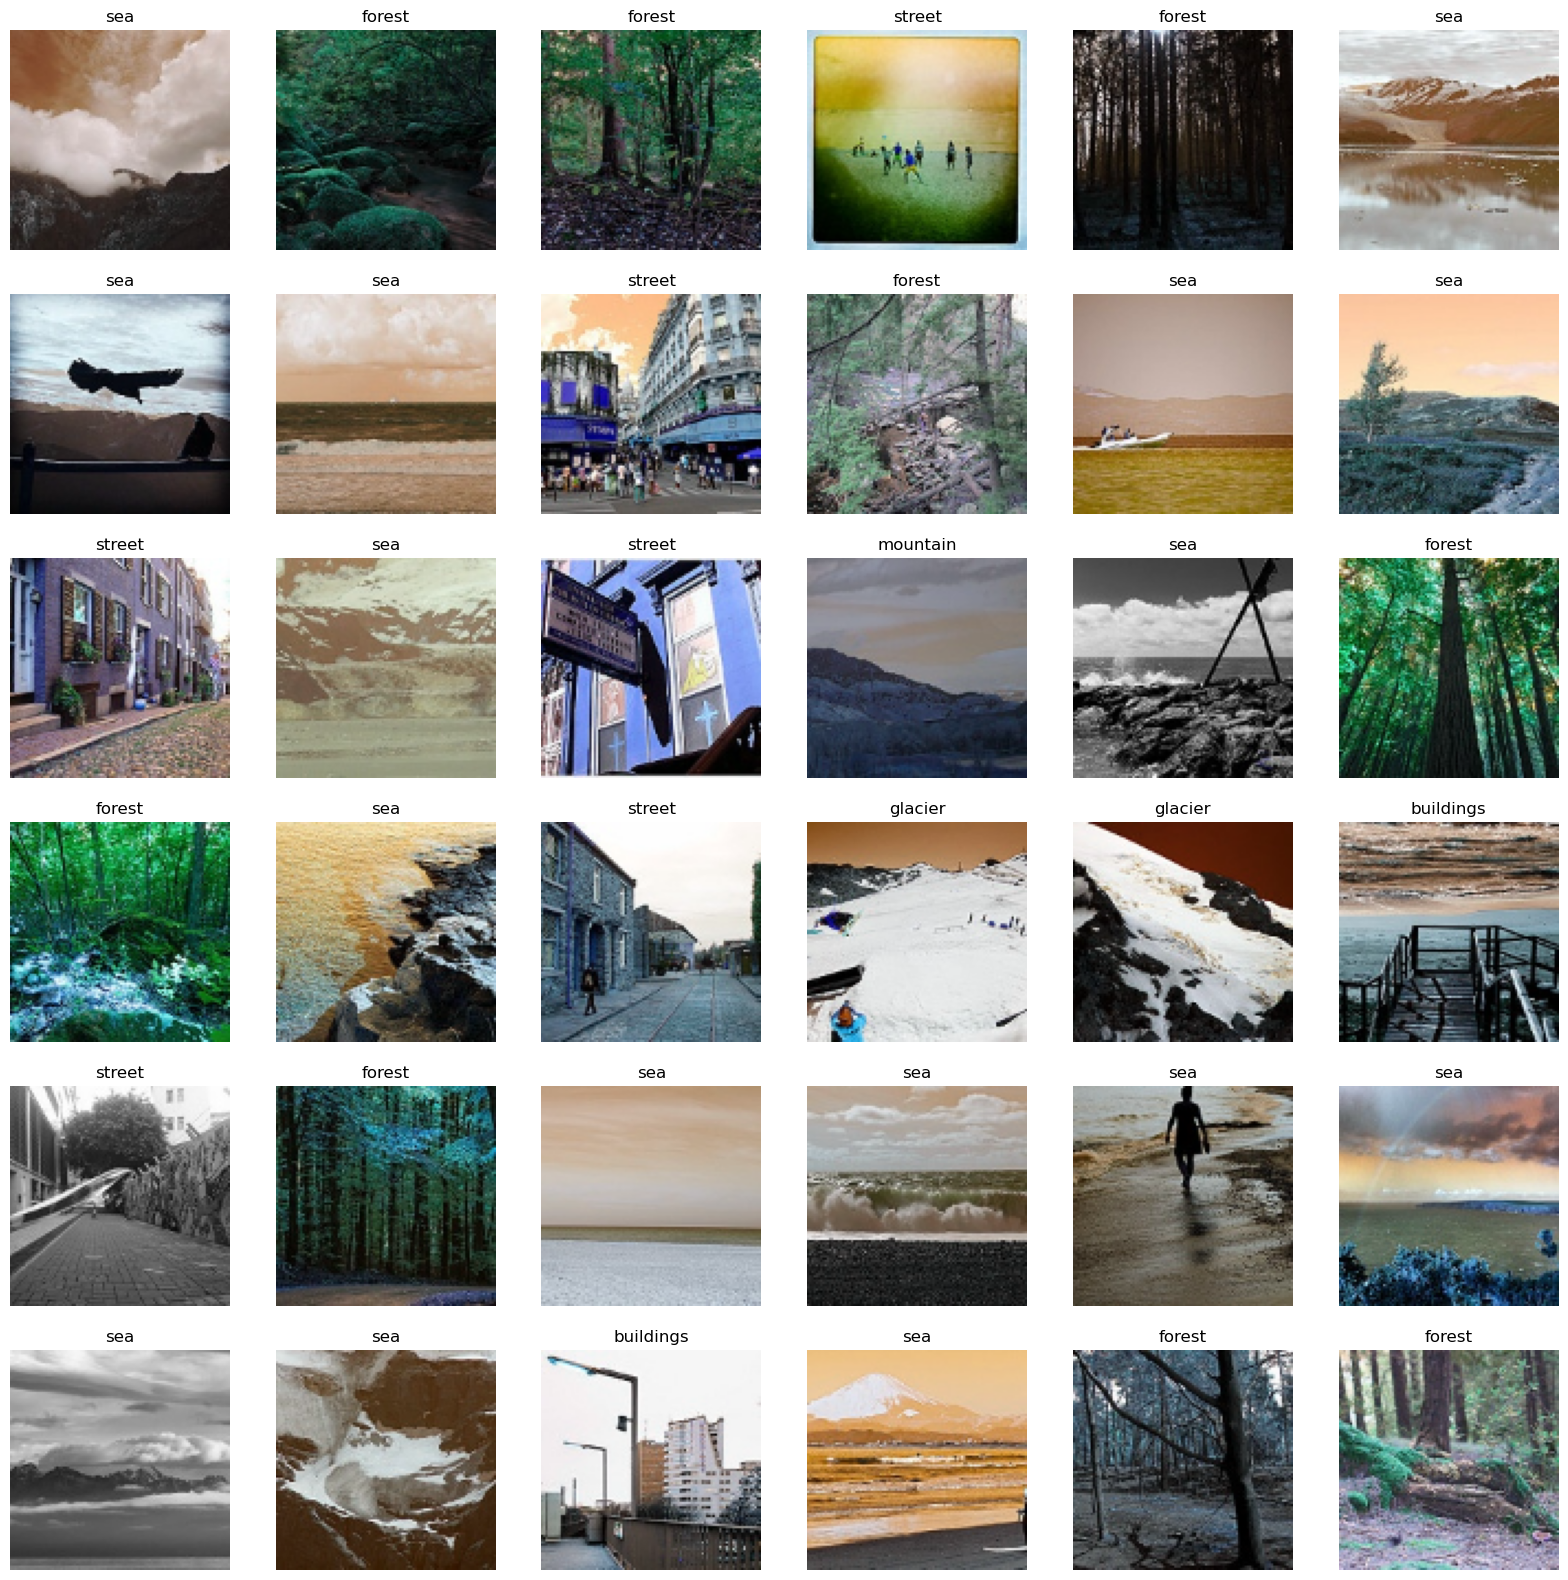

In [34]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(x_pred),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(x_pred[i])
    plt.axis('off')
    plt.title(get_code(np.argmax(y_result[i])))

In [35]:
y_pred = KerasModel.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

labels = list(code.values())
target_names = list(code.keys())
report = classification_report(y_test, y_pred_classes, labels=labels, target_names=target_names)

print(report)

from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_classes, labels=labels, target_names=target_names)

print(report)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_classes, labels=labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')


94/94 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step
              precision    recall  f1-score   support

   buildings       0.86      0.54      0.67       437
      forest       0.96      0.88      0.92       474
     glacier       0.73      0.70      0.72       553
    mountain       0.80      0.62      0.70       525
         sea       0.64      0.84      0.73       510
      street       0.67      0.91      0.77       501

    accuracy                           0.75      3000
   macro avg       0.78      0.75      0.75      3000
weighted avg       0.77      0.75      0.75      3000

              precision    recall  f1-score   support

   buildings       0.86      0.54      0.67       437
      forest       0.96      0.88      0.92       474
     glacier       0.73      0.70      0.72       553
    mountain       0.80      0.62      0.70       525
         sea       0.64      0.84      0.73       510
      street       0.67      0.91      0.77       501

    accuracy                         

In [52]:
num_classes = 6

# Convert to DataFrame for easier manipulation
train_df = pd.DataFrame({'data': list(x_train), 'label': y_train})

# Ensure we sample 1000 from each category to total 6000
sampled_train_df = train_df.groupby('label').apply(lambda x: x.sample(n=1000, random_state=42)).reset_index(drop=True)

# Prepare the training data
xx_train = np.array(list(sampled_train_df['data']))
yy_train = to_categorical(np.array(sampled_train_df['label']), num_classes=num_classes)

# Create a DataFrame from the test dataset
test_df = pd.DataFrame({'data': list(x_test), 'label': y_test})

# Sample 400 random elements from the entire dataset
sampled_test_df = test_df.sample(n=400, random_state=42).reset_index(drop=True)

# Prepare the testing data
xx_test = np.array(list(sampled_test_df['data']))
yy_test = to_categorical(np.array(sampled_test_df['label']), num_classes=num_classes)


xx_train = xx_train.astype('float32')/255
xx_test = xx_test.astype('float32')/255
yy_train = yy_train.astype('int')
yy_test = yy_test.astype('int')

print("Training data shape:", xx_train.shape)  
print("Test data shape:", xx_test.shape)       


Training data shape: (6000, 100, 100, 3)
Test data shape: (400, 100, 100, 3)


In [56]:
train_datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

# Create generators
train_generator = train_datagen.flow(
    xx_train,
    yy_train,
    batch_size=16
)

val_generator = val_datagen.flow(
    xx_test,
    yy_test,
    batch_size=16
)

In [88]:
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=2, 
    min_lr=1e-6,
    verbose=1  # Set verbose to 1 to get updates in the training log
)
vgg16_save_path = 'D:/Computer vision/project/vgg16.keras'  # Specify your desired path and filename
checkpoint16 = ModelCheckpoint(vgg16_save_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')


def vgg16_architecture():
    base_model = VGG16(include_top=False, weights="imagenet", input_shape=(100, 100, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    output = Dense(num_classes, activation='softmax')(x)

    VGG16_model = Model(inputs=base_model.input, outputs=output)

    VGG16_model.summary()

    optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
    VGG16_model.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])

    return VGG16_model

In [81]:
vgg19_save_path = 'D:/Computer vision/project/vgg19.keras'  # Specify your desired path and filename
checkpoint19 = ModelCheckpoint(vgg19_save_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

def vgg19_architecture():
    from keras.applications import VGG19
    base_model = VGG19(include_top=False, weights="imagenet", input_shape=(100, 100, 3))
    from keras.layers import BatchNormalization, Dropout

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.30)(x)

    output = Dense(6, activation='softmax')(x)

    VGG19_model = Model(inputs=base_model.input, outputs=output)

    VGG19_model.summary()

    optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
    VGG19_model.compile(optimizer=optimizer, loss = categorical_crossentropy, metrics=['accuracy'])

    return VGG19_model

In [57]:
res_save_path = 'D:/Computer vision/project/ResNet.keras'  # Specify your desired path and filename
checkpointres = ModelCheckpoint(vgg19_save_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

def resnet152v2_architecture():
    from keras.applications import ResNet152V2
    base_model = ResNet152V2(include_top=False, weights="imagenet", input_shape=(100, 100, 3))
    from keras.layers import BatchNormalization, Dropout

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.30)(x)

    output = Dense(6, activation='softmax')(x)

    ResNet152V2_model = Model(inputs=base_model.input, outputs=output)

    ResNet152V2_model.summary()

    optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
    ResNet152V2_model.compile(optimizer=optimizer, loss = categorical_crossentropy, metrics=['accuracy'])

    return ResNet152V2_model

In [74]:
in_save_path = 'D:/Computer vision/project/Inception.keras'  # Specify your desired path and filename
checkpoint = ModelCheckpoint(in_save_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

def inception_v3_architecture():
    from keras.applications import InceptionV3
    
    from keras.layers import BatchNormalization, Dropout

    base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=(100, 100, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.30)(x)

    output = Dense(6, activation='softmax')(x)

    InceptionV3_model = Model(inputs=base_model.input, outputs=output)

    InceptionV3_model.summary()

    optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
    InceptionV3_model.compile(optimizer=optimizer, loss = categorical_crossentropy, metrics=['accuracy'])

    return InceptionV3_model

In [87]:
def evaluate_model(model, xx_test, yy_test):
    loss, accuracy = model.evaluate(xx_test, yy_test, verbose=0)
    print(f"Loss: {loss}")
    print(f"Accuracy: {accuracy}")
    return loss, accuracy

    # cm = confusion_matrix(y_true, y_pred)
    # print("Confusion Matrix:")
    # print(cm)

    # cr = classification_report(y_true, y_pred, target_names=[f'class_{i}' for i in range(3)])
    # print("Classification Report:")
    # print(cr)

    # return cm, cr


 

In [89]:
models = {
     "VGG16": vgg16_architecture,
    #  "VGG19": vgg19_architecture,
    #  "ResNet152V2": resnet152v2_architecture,
    #  "InceptionV3": inception_v3_architecture
}

for model_name, model_func in models.items():
    print(f"Training {model_name}...")
    model = model_func()
    model.fit(
        train_generator,
        validation_data=val_generator,
        steps_per_epoch=75,  # Adjust epochs as needed
        epochs=5,
        validation_steps=5,
        callbacks=[early,lr_reducer,checkpoint16]
    )
    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_______________________________________________________________________")

Training VGG16...


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_160         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,814 (56.15 MB)

 Trainable params: 14,718,790 (56.15 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4866 - loss: 1.3595
Epoch 1: val_accuracy improved from -inf to 0.67500, saving model to D:/Computer vision/project/vgg16.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.4878 - loss: 1.3564 - val_accuracy: 0.6750 - val_loss: 0.8420 - learning_rate: 1.0000e-04
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6483 - loss: 0.9325
Epoch 2: val_accuracy improved from 0.67500 to 0.70000, saving model to D:/Computer vision/project/vgg16.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.6485 - loss: 0.9323 - val_accuracy: 0.7000 - val_loss: 0.8835 - learning_rate: 1.0000e-04
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7386 - loss: 0.7680
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 3: val_accuracy did not improve from 0.70000
75/75 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.7384 - loss: 0.7682 - val_accuracy: 0.6250 - val_loss: 1.3188 - 

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

def generate_confusion_matrix_and_metrics(model, x_test, y_test):
    # Generate predictions
    y_pred = model.predict(x_test)
    
    # Check the shape of y_pred and y_test
    print(f"y_pred shape: {y_pred.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Handle binary and multi-class predictions
    if len(y_pred.shape) == 1:  # Binary classification
        y_pred_classes = (y_pred > 0.5).astype(int)
    else:  # Multi-class classification
        y_pred_classes = np.argmax(y_pred, axis=1)

    # Check the shape after prediction conversion
    print(f"y_pred_classes shape: {y_pred_classes.shape}")

    # Check true labels
    if len(y_test.shape) == 1:  # if y_test is one-dimensional
        y_true = y_test.astype(int)  # assuming y_test contains class indices directly
    else:
        y_true = np.argmax(y_test, axis=1)  # True classes in one-hot encoded format

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y_true), 
                yticklabels=np.unique(y_true))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Classification report
    labels = np.unique(y_true)
    target_names = [f'class_{label}' for label in labels]
    report = classification_report(y_true, y_pred_classes, labels=labels, target_names=target_names)
    print("Classification Report:")
    print(report)

    # Precision, Recall, F1-score
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, labels=labels, average='weighted')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1_score:.4f}')

    return cm, report, precision, recall, f1_score


94/94 ━━━━━━━━━━━━━━━━━━━━ 73s 768ms/step
y_pred shape: (3000, 6)
y_test shape: (3000,)
y_pred_classes shape: (3000,)


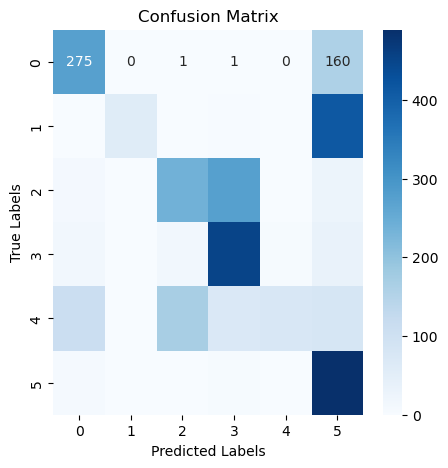

Classification Report:
              precision    recall  f1-score   support

     class_0       0.65      0.63      0.64       437
     class_1       1.00      0.12      0.22       474
     class_2       0.56      0.43      0.48       553
     class_3       0.56      0.86      0.68       525
     class_4       0.94      0.15      0.26       510
     class_5       0.41      0.98      0.57       501

    accuracy                           0.53      3000
   macro avg       0.69      0.53      0.48      3000
weighted avg       0.68      0.53      0.48      3000

Precision: 0.6815
Recall: 0.5297
F1-score: 0.4764


(array([[275,   0,   1,   1,   0, 160],
        [  0,  59,   0,   2,   0, 413],
        [ 11,   0, 237, 276,   1,  28],
        [ 17,   0,  17, 452,   4,  35],
        [109,   0, 170,  72,  77,  82],
        [  8,   0,   0,   4,   0, 489]], dtype=int64),
 '              precision    recall  f1-score   support\n\n     class_0       0.65      0.63      0.64       437\n     class_1       1.00      0.12      0.22       474\n     class_2       0.56      0.43      0.48       553\n     class_3       0.56      0.86      0.68       525\n     class_4       0.94      0.15      0.26       510\n     class_5       0.41      0.98      0.57       501\n\n    accuracy                           0.53      3000\n   macro avg       0.69      0.53      0.48      3000\nweighted avg       0.68      0.53      0.48      3000\n',
 0.6814792491770546,
 0.5296666666666666,
 0.4764197192075645)

In [91]:
generate_confusion_matrix_and_metrics(model, x_test, y_test)


In [82]:
models = {
    # "VGG16": vgg16_architecture,
    "VGG19": vgg19_architecture,
    #  "ResNet152V2": resnet152v2_architecture,
    #  "InceptionV3": inception_v3_architecture
}

for model_name, model_func in models.items():
    print(f"Training {model_name}...")
    model = model_func()
    model.fit(
       train_generator,
        validation_data=val_generator,
        steps_per_epoch=75,  # Adjust epochs as needed
        epochs=5,
        validation_steps=5,
        callbacks=[early,lr_reducer,checkpoint19]
    )
    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_______________________________________________________________________")

Training VGG19...


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_159         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 20,029,510 (76.41 MB)

 Trainable params: 20,028,486 (76.40 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2933 - loss: 1.8118
Epoch 1: val_accuracy improved from -inf to 0.16250, saving model to D:/Computer vision/project/vgg19.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.2933 - loss: 1.8114 - val_accuracy: 0.1625 - val_loss: 3.2757 - learning_rate: 0.0100
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3097 - loss: 1.7679
Epoch 2: val_accuracy improved from 0.16250 to 0.18750, saving model to D:/Computer vision/project/vgg19.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.3101 - loss: 1.7665 - val_accuracy: 0.1875 - val_loss: 160.8743 - learning_rate: 0.0100
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3614 - loss: 1.8090
Epoch 3: val_accuracy did not improve from 0.18750
75/75 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.3613 - loss: 1.8081 - val_accuracy: 0.1625 - val_loss: 2.4370 - learning_rate: 0.0100
Epoch 3: early stopping
Evaluating VGG19...
Loss: 2.5200276374

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

def generate_confusion_matrix_and_metrics(model, x_pred, y_test):
    # Generate predictions
    y_pred = model.predict(x_pred)
    
    # Check the shape of y_pred and y_test
    print(f"y_pred shape: {y_pred.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Handle binary and multi-class predictions
    if len(y_pred.shape) == 1:  # Binary classification
        y_pred_classes = (y_pred > 0.5).astype(int)
    else:  # Multi-class classification
        y_pred_classes = np.argmax(y_pred, axis=1)

    # Check the shape after prediction conversion
    print(f"y_pred_classes shape: {y_pred_classes.shape}")

    # Check true labels
    if len(y_test.shape) == 1:  # if y_test is one-dimensional
        y_true = y_test.astype(int)  # assuming y_test contains class indices directly
    else:
        y_true = np.argmax(y_test, axis=1)  # True classes in one-hot encoded format

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y_true), 
                yticklabels=np.unique(y_true))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Classification report
    labels = np.unique(y_true)
    target_names = [f'class_{label}' for label in labels]
    report = classification_report(y_true, y_pred_classes, labels=labels, target_names=target_names)
    print("Classification Report:")
    print(report)

    # Precision, Recall, F1-score
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, labels=labels, average='weighted')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1_score:.4f}')

    return cm, report, precision, recall, f1_score

94/94 ━━━━━━━━━━━━━━━━━━━━ 93s 980ms/step
y_pred shape: (3000, 6)
y_test shape: (3000,)
y_pred_classes shape: (3000,)


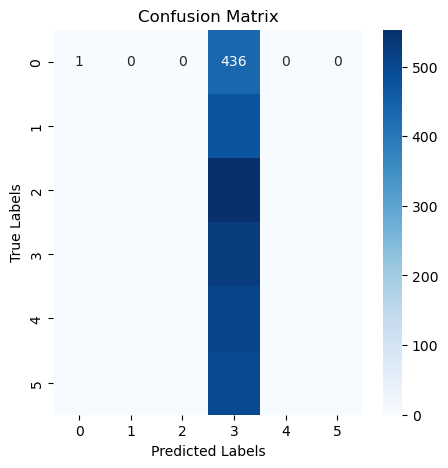

Classification Report:
              precision    recall  f1-score   support

     class_0       1.00      0.00      0.00       437
     class_1       0.00      0.00      0.00       474
     class_2       0.00      0.00      0.00       553
     class_3       0.18      1.00      0.30       525
     class_4       0.00      0.00      0.00       510
     class_5       0.00      0.00      0.00       501

    accuracy                           0.18      3000
   macro avg       0.20      0.17      0.05      3000
weighted avg       0.18      0.18      0.05      3000

Precision: 0.1763
Recall: 0.1753
F1-score: 0.0528


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packag

(array([[  1,   0,   0, 436,   0,   0],
        [  0,   0,   0, 474,   0,   0],
        [  0,   0,   0, 553,   0,   0],
        [  0,   0,   0, 525,   0,   0],
        [  0,   0,   0, 510,   0,   0],
        [  0,   0,   0, 501,   0,   0]], dtype=int64),
 '              precision    recall  f1-score   support\n\n     class_0       1.00      0.00      0.00       437\n     class_1       0.00      0.00      0.00       474\n     class_2       0.00      0.00      0.00       553\n     class_3       0.18      1.00      0.30       525\n     class_4       0.00      0.00      0.00       510\n     class_5       0.00      0.00      0.00       501\n\n    accuracy                           0.18      3000\n   macro avg       0.20      0.17      0.05      3000\nweighted avg       0.18      0.18      0.05      3000\n',
 0.17630187840391243,
 0.17533333333333334,
 0.052807596356015805)

In [84]:
generate_confusion_matrix_and_metrics(model, x_test, y_test)

In [60]:
models = {
    # "VGG16": vgg16_architecture,
    # "VGG19": vgg19_architecture,
    "ResNet152V2": resnet152v2_architecture,
    #  "InceptionV3": inception_v3_architecture
}

for model_name, model_func in models.items():
    print(f"Training {model_name}...")
    model = model_func()
    model.fit(
        train_generator,
        validation_data=val_generator,
        steps_per_epoch=75,  # Adjust epochs as needed
        epochs=5,
        validation_steps=5,
        callbacks=[early,checkpointres,lr_reducer]
    )
    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_______________________________________________________________________")

Training ResNet152V2...


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 106, 106,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 52, 52,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 25, 25,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 25, 25,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 25, 25,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 27, 27,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 25, 25,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 25, 25,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 25, 25,    │          0 │ conv2_block1_0_c

 Total params: 58,352,134 (222.60 MB)

 Trainable params: 58,204,294 (222.03 MB)

 Non-trainable params: 147,840 (577.50 KB)

Epoch 1/5


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3035 - loss: 1.9965
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to D:/Computer vision/project/vgg19.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 452s 4s/step - accuracy: 0.3055 - loss: 1.9902 - val_accuracy: 0.5625 - val_loss: 1.4646 - learning_rate: 1.0000e-04
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6616 - loss: 1.0133
Epoch 2: val_accuracy improved from 0.56250 to 0.72500, saving model to D:/Computer vision/project/vgg19.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 266s 4s/step - accuracy: 0.6620 - loss: 1.0127 - val_accuracy: 0.7250 - val_loss: 1.0417 - learning_rate: 1.0000e-04
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6911 - loss: 0.9726
Epoch 3: val_accuracy improved from 0.72500 to 0.83750, saving model to D:/Computer vision/project/vgg19.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 266s 4s/step - accuracy: 0.6911 - loss: 0.9723 - val_accuracy: 0.8375 - val_loss: 0.5724 - learning_rate: 1.0000e-04
Ep

In [69]:

def generate_confusion_matrix_and_metrics(model, x_test, y_test):
    # Generate predictions
    y_pred = model.predict(x_test)
    
    # Check the shape of y_pred and y_test
    print(f"y_pred shape: {y_pred.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Handle binary and multi-class predictions
    if len(y_pred.shape) == 1:  # Binary classification
        y_pred_classes = (y_pred > 0.5).astype(int)
    else:  # Multi-class classification
        y_pred_classes = np.argmax(y_pred, axis=1)

    # Check the shape after prediction conversion
    print(f"y_pred_classes shape: {y_pred_classes.shape}")

    # Check true labels
    if len(y_test.shape) == 1:  # if y_test is one-dimensional
        y_true = y_test.astype(int)  # assuming y_test contains class indices directly
    else:
        y_true = np.argmax(y_test, axis=1)  # True classes in one-hot encoded format

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y_true), 
                yticklabels=np.unique(y_true))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Classification report
    labels = np.unique(y_true)
    target_names = [f'class_{label}' for label in labels]
    report = classification_report(y_true, y_pred_classes, labels=labels, target_names=target_names)
    print("Classification Report:")
    print(report)

    # Precision, Recall, F1-score
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, labels=labels, average='weighted')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1_score:.4f}')

    return cm, report, precision, recall, f1_score

94/94 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step
y_pred shape: (3000, 6)
y_test shape: (3000,)
y_pred_classes shape: (3000,)


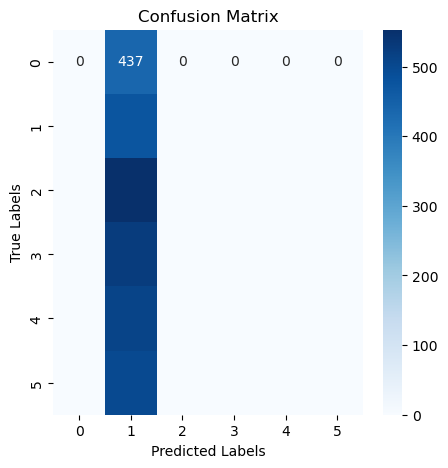

Classification Report:
              precision    recall  f1-score   support

     class_0       0.00      0.00      0.00       437
     class_1       0.16      1.00      0.27       474
     class_2       0.00      0.00      0.00       553
     class_3       0.00      0.00      0.00       525
     class_4       0.00      0.00      0.00       510
     class_5       0.00      0.00      0.00       501

    accuracy                           0.16      3000
   macro avg       0.03      0.17      0.05      3000
weighted avg       0.02      0.16      0.04      3000

Precision: 0.0250
Recall: 0.1580
F1-score: 0.0431


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packag

(array([[  0, 437,   0,   0,   0,   0],
        [  0, 474,   0,   0,   0,   0],
        [  0, 553,   0,   0,   0,   0],
        [  0, 525,   0,   0,   0,   0],
        [  0, 510,   0,   0,   0,   0],
        [  0, 501,   0,   0,   0,   0]], dtype=int64),
 '              precision    recall  f1-score   support\n\n     class_0       0.00      0.00      0.00       437\n     class_1       0.16      1.00      0.27       474\n     class_2       0.00      0.00      0.00       553\n     class_3       0.00      0.00      0.00       525\n     class_4       0.00      0.00      0.00       510\n     class_5       0.00      0.00      0.00       501\n\n    accuracy                           0.16      3000\n   macro avg       0.03      0.17      0.05      3000\nweighted avg       0.02      0.16      0.04      3000\n',
 0.024964,
 0.158,
 0.04311571675302245)

In [72]:
generate_confusion_matrix_and_metrics(model1, x_test, y_test)

In [75]:
models = {
    # "VGG16": vgg16_architecture,
    # "VGG19": vgg19_architecture,
    # "ResNet152V2": resnet152v2_architecture,
    "InceptionV3": inception_v3_architecture
}

for model_name, model_func in models.items():
    print(f"Training {model_name}...")
    model = model_func()
    model.fit(
       train_generator,
        validation_data=val_generator,
        steps_per_epoch=75,  # Adjust epochs as needed
        epochs=5,
        validation_steps=5,
        callbacks=[early,checkpoint,lr_reducer]
    )
    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_______________________________________________________________________")

Training InceptionV3...


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 49, 49,    │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 49,    │         96 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 49, 49,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 47, 47,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 47,    │         96 │ conv2d_61[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 47, 47,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 47, 47,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 47,    │        192 │ conv2d_62[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 47, 47,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 23, 23,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 23, 23,    │      5,120 │ max_pooling2d_19… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 23, 23,    │        240 │ conv2d_63[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 23, 23,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 21, 21,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 21,    │        576 │ conv2d_64[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 21, 21,    │          0 │ batch_normalizat

 Total params: 21,823,270 (83.25 MB)

 Trainable params: 21,784,742 (83.10 MB)

 Non-trainable params: 38,528 (150.50 KB)

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.2137 - loss: 2.4815
Epoch 1: val_accuracy improved from -inf to 0.41250, saving model to D:/Computer vision/project/Inception.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 140s 892ms/step - accuracy: 0.2147 - loss: 2.4770 - val_accuracy: 0.4125 - val_loss: 1.3640 - learning_rate: 1.0000e-04
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.4022 - loss: 1.7844
Epoch 2: val_accuracy improved from 0.41250 to 0.48750, saving model to D:/Computer vision/project/Inception.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 64s 852ms/step - accuracy: 0.4025 - loss: 1.7832 - val_accuracy: 0.4875 - val_loss: 2.0087 - learning_rate: 1.0000e-04
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.5416 - loss: 1.4659
Epoch 3: val_accuracy improved from 0.48750 to 0.65000, saving model to D:/Computer vision/project/Inception.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 64s 852ms/step - accuracy: 0.5414 - loss: 1.4658 - val_accuracy: 0.6500 - val_loss:

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

def generate_confusion_matrix_and_metrics(model, x_test, y_test):
    # Generate predictions
    y_pred = model.predict(x_test)
    
    # Check the shape of y_pred and y_test
    print(f"y_pred shape: {y_pred.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Handle binary and multi-class predictions
    if len(y_pred.shape) == 1:  # Binary classification
        y_pred_classes = (y_pred > 0.5).astype(int)
    else:  # Multi-class classification
        y_pred_classes = np.argmax(y_pred, axis=1)

    # Check the shape after prediction conversion
    print(f"y_pred_classes shape: {y_pred_classes.shape}")

    # Check true labels
    if len(y_test.shape) == 1:  # if y_test is one-dimensional
        y_true = y_test.astype(int)  # assuming y_test contains class indices directly
    else:
        y_true = np.argmax(y_test, axis=1)  # True classes in one-hot encoded format

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y_true), 
                yticklabels=np.unique(y_true))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Classification report
    labels = np.unique(y_true)
    target_names = [f'class_{label}' for label in labels]
    report = classification_report(y_true, y_pred_classes, labels=labels, target_names=target_names)
    print("Classification Report:")
    print(report)

    # Precision, Recall, F1-score
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, labels=labels, average='weighted')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1_score:.4f}')

    return cm, report, precision, recall, f1_score

94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 253ms/step
y_pred shape: (3000, 6)
y_test shape: (3000,)
y_pred_classes shape: (3000,)


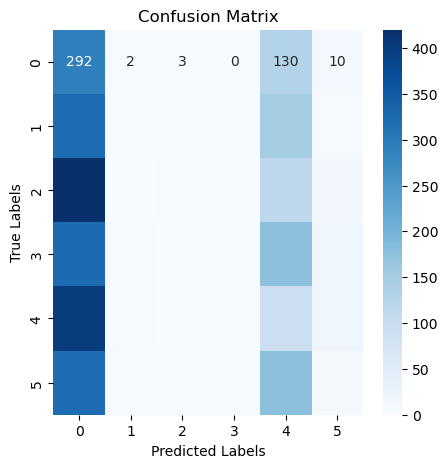

Classification Report:
              precision    recall  f1-score   support

     class_0       0.14      0.67      0.23       437
     class_1       0.00      0.00      0.00       474
     class_2       0.29      0.00      0.01       553
     class_3       0.00      0.00      0.00       525
     class_4       0.11      0.18      0.14       510
     class_5       0.08      0.01      0.02       501

    accuracy                           0.13      3000
   macro avg       0.10      0.14      0.07      3000
weighted avg       0.10      0.13      0.06      3000

Precision: 0.1048
Recall: 0.1303
F1-score: 0.0612


(array([[292,   2,   3,   0, 130,  10],
        [320,   0,   1,   0, 150,   3],
        [420,   0,   2,   1, 118,  12],
        [325,   4,   1,   0, 177,  18],
        [399,   3,   0,   0,  92,  16],
        [320,   0,   0,   0, 176,   5]], dtype=int64),
 '              precision    recall  f1-score   support\n\n     class_0       0.14      0.67      0.23       437\n     class_1       0.00      0.00      0.00       474\n     class_2       0.29      0.00      0.01       553\n     class_3       0.00      0.00      0.00       525\n     class_4       0.11      0.18      0.14       510\n     class_5       0.08      0.01      0.02       501\n\n    accuracy                           0.13      3000\n   macro avg       0.10      0.14      0.07      3000\nweighted avg       0.10      0.13      0.06      3000\n',
 0.10475508976651192,
 0.13033333333333333,
 0.06124311817545682)

In [77]:
generate_confusion_matrix_and_metrics(model, x_test, y_test)

## In the code above, I have provided you with a written code, but it contains errors. Each of you must trace the errors and improve the accuracy for each model, recording the changes in the table below. Then, answer the following questions.

| Network          | Accuracy | Recall | Precision | F1-Score |
|------------------|----------|--------|-----------|----------|
| Your CNN model   |  0.75    | 0.7503 |   0.7708  |   0.748  |
| VGG16            |  0.53    | 0.5297 |  0.6815   |  0.4764  |
| VGG19            |    0.18  | 0.1753 | 0.1763    | 0.0528   |
| RasNet152V2      |  0.13    |   0.13 | 0.1048    | 0.0612   |
| Inception_V3     |    0.16  | 0.158  |  0.025    |  0.043   |


# Experimental Results 